In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm

%matplotlib inline

In [2]:
datapath = '/home/droumis/data/Steinmetz-2019/npz/'

fname = []
for j in range(3):
  fname.append(f'{datapath}steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load(f'{datapath}steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [5]:
dat = alldat[7]

In [4]:
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

In [6]:
ILA = np.where([dat['brain_area'] == 'ILA'])[1]
PLA = np.where([dat['brain_area'] == 'PL'])[1]
CA1 = np.where([dat['brain_area'] == 'CA1'])[1]
VISp = np.where([dat['brain_area'] == 'VISp'])[1]

In [23]:
start_bin = 0 # in 10ms bin units
end_bin = 250 # in 10ms bin units
barea = CA1

NN = len(barea) # number of neurons
NT = end_bin - start_bin # number of time bins
NTRIALS = len(response) # number of neurons

FR = dat['spks'][barea,:,start_bin:end_bin].transpose(0,2,1)
# FR = np.reshape(dat['spks'][barea,:,start_bin:end_bin], (NN,-1))


In [24]:
FR.shape

(56, 250, 250)

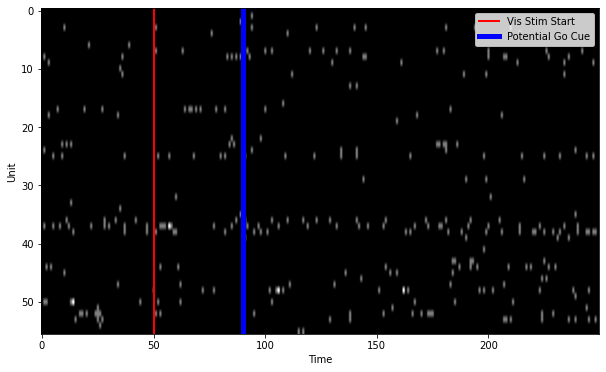

In [25]:
# Display a spike raster of the image
plt.figure(figsize=(10,6))
plt.imshow(FR[:,:,23], aspect='auto', cmap='gray')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = FR.shape[1]
vis_start = 50
go_cue = 90

plt.axvline(x=vis_start, color='red', linewidth=2, label='Vis Stim Start')
plt.axvline(x=go_cue, color='blue', linewidth=5, label='Potential Go Cue')
plt.ylabel("Unit")
plt.xlabel("Time")
plt.legend()
plt.tight_layout
plt.show()

In [26]:
def format_spikes(FR, idx):
    datas = []
    for i in idx:
        spikes_cur = np.squeeze(FR[:,:,i])

        # remove columns which contain NaNs
        idx_keep = np.invert(np.any(np.isnan(spikes_cur), axis=0))
        spikes_cur = spikes_cur[:,idx_keep]

        # Transpose the data for passing to SSM fit function
        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(spikes_cur.T, dtype=int))
    return datas

In [ ]:
target_idx = vars_dict['target_idx']
train_idx = vars_dict['train_idx']
test_idx = vars_dict['test_idx']
# We get the indices of all reaches to the left as target_inds[0]
# and all reaches to the right as target_inds[7]
left_reach_idx = set(target_idx[0])
right_reach_idx = set(target_idx[7])

train_right_idx = list(right_reach_idx.intersection(train_idx))
train_left_idx = list(left_reach_idx.intersection(train_idx))

test_right_idx = list(right_reach_idx.intersection(test_idx))
test_left_idx = list(left_reach_idx.intersection(test_idx))

train_idx_combined = train_right_idx + train_left_idx
test_idx_combined = test_right_idx + test_left_idx

train_datas = format_spikes(FR, train_idx_combined)
test_datas = format_spikes(FR, test_idx_combined)

In [ ]:
num_states = 5
num_neurons = train_datas[0].shape[1]

# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0, 0, 0, 0]))
# Create our HMM
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="standard",
                     init_state_distn=init_dist)


# Manually initialize the means for each state
lambdas_baseline = np.nanmean(FR[:,base_idx,:], axis=(1,2))
left_trials = FR[:,:,train_left_idx]
right_trials = FR[:,:,train_right_idx]

lambdas_plan_left = np.nanmean(left_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_left = np.nanmean(left_trials[:,move_idx,:], axis=(1,2))

lambdas_plan_right = np.nanmean(right_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_right = np.nanmean(right_trials[:,move_idx,:], axis=(1,2))

lambdas = np.vstack((lambdas_baseline,
                     lambdas_plan_right,
                     lambdas_move_right,
                     lambdas_plan_left,
                     lambdas_move_left))

# Manually initialize the transition probabilities
A = np.array(
[[0.8, 0.1, 0, 0.1, 0],
[0, 0.9, 0.1, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 0.9, 0.1],
[0, 0, 0, 0, 1]]
)

In [ ]:

simple_hmm.log_lambdas = np.log(lambdas + 1e-16)
simple_hmm.transitions.log_Ps = np.log(A + 1e-16)
lls = simple_hmm.fit(train_datas, method='em')

In [ ]:
# get a random reach
test_trial_spikes = np.random.choice(train_datas)
posterior = simple_hmm.filter(test_trial_spikes)

In [ ]:
# plot posterior of states for a single test trial
plt.figure(figsize=(10, 4))
for i in range(num_states):
    plt.plot(posterior[:,i], label="State %d" % i)
plt.legend()